In [1]:
# ============================================================
# CELL 1: Project Setup
# ============================================================
import os
from pathlib import Path

print("=" * 60)
print("PROJECT SETUP - KAGGLE")
print("=" * 60)
print("\n✓ Running on Kaggle")
print("  • Data will be saved to /kaggle/working/")
print("  • Spotify dataset should be attached as input dataset")
print("\nNext steps:")
print("  1. Attach 'spotify-1million-tracks' dataset in Kaggle")
print("  2. Run remaining cells in order")

PROJECT SETUP - KAGGLE

✓ Running on Kaggle
  • Data will be saved to /kaggle/working/
  • Spotify dataset should be attached as input dataset

Next steps:
  1. Attach 'spotify-1million-tracks' dataset in Kaggle
  2. Run remaining cells in order


In [2]:
# ============================================================
# CELL 2: Skip Drive Setup (Kaggle Only)
# ============================================================
def sync_to_drive(source_path, drive_path=None, verbose=False):
    """Stub function for Kaggle (no Drive) - silent"""
    return False

print("✓ Running in Kaggle - Spotify dataset should be attached as input")
print("✓ Outputs will be saved to /kaggle/working/")

✓ Running in Kaggle - Spotify dataset should be attached as input
✓ Outputs will be saved to /kaggle/working/


In [3]:
# ============================================================
# CELL 3: Environment Setup & Install Dependencies
# ============================================================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Install dependencies
import subprocess
import sys

print("Installing dependencies...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                      "protobuf>=5.29.1,<7.0.0"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                      "transformers", "torch", "torchvision", "faiss-cpu",
                      "pyarrow>=14.0.0,<20.0.0", "datasets", "pillow",
                      "scikit-learn", "tqdm", "matplotlib"])
print("✓ Dependencies installed")

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.4 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


✓ Dependencies installed


In [4]:
# ============================================================
# CELL 4: Imports & Configuration
# ============================================================
import math
import json
import random
import shutil
import pickle
import warnings
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

from transformers import (
    CLIPImageProcessor,
    CLIPVisionModel,
)
import faiss
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
SEED = 42
DATA_DIR = Path('/kaggle/working/data')
CHECKPOINT_DIR = Path('/kaggle/working/checkpoints')
EMID_DIR = Path('/kaggle/working/emid')
SPOTIFY_DATASET_PATH = Path('/kaggle/input/spotify-1million-tracks/spotify_data.csv')

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(EMID_DIR, exist_ok=True)

def seed_everything(seed: int = SEED):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup device and seed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
seed_everything()
print(f"✓ Random seed set to {SEED}")

E0000 00:00:1765082106.470649      82 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765082106.594620      82 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ Device: cuda
✓ Random seed set to 42


In [5]:
# ==== INSTALL RCLONE ====
!curl https://rclone.org/install.sh | sudo bash

# ==== COPY CONFIG FROM UPLOADED DATASET ====
!mkdir -p ~/.config/rclone/
!cp /kaggle/input/rclone/rclone.conf ~/.config/rclone/rclone.conf

# ==== VERIFY RCLONE CONFIG ====
print("Verifying rclone configuration...")
!rclone listremotes

# ==== TEST CONNECTION ====
print("\nTesting Google Drive connection...")
!rclone lsd gdrive:

# ==== CREATE OUTPUT DIRECTORIES ====
print("\nCreating output directories...")
!mkdir -p /kaggle/working/output
!mkdir -p /kaggle/working/checkpoints
!mkdir -p /kaggle/working/data

# ==== CREATE GOOGLE DRIVE DIRECTORIES ====
print("\nCreating Google Drive directories...")
!rclone mkdir gdrive:kaggle_outputs
!rclone mkdir gdrive:kaggle_outputs/checkpoints
!rclone mkdir gdrive:kaggle_outputs/data
!rclone mkdir gdrive:kaggle_outputs/emid

print("Setup complete!")
print(f"Local checkpoint directory: /kaggle/working/checkpoints")
print(f"Files will be synced to: gdrive:kaggle_outputs/")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4734  100  4734    0     0  10305      0 --:--:-- --:--:-- --:--:-- 10291
Archive:  rclone-current-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.72.0-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.72.0-linux-amd64/rclone  [binary]
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.72.0-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.72.0-linux-amd64/README.html  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.72.0-linux-amd64/rclone.1  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.72.0-linux-amd64/git-log.txt  [text]  
Purging old database entries in /usr/share/man...
Processing manual pages under /usr/share/man...
Purging old database entries in /usr/share/man/pl...
Processing manual pages under /usr/share/man/pl...
Purging old database entries

In [6]:
# ============================================================
# CELL 5: Audio Features & Emotion Configuration
# ============================================================
AUDIO_FEATURES = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature'
]

EMOTIONS = ['anger', 'amusement', 'awe', 'contentment', 'excitement', 'fear', 'sadness']
EMOTION_TO_IDX = {e: i for i, e in enumerate(EMOTIONS)}

def map_to_emotion_improved(valence: float, energy: float, acousticness: float, 
                            danceability: float) -> str:
    """
    Improved emotion mapping using 4 audio features.
    Based on Russell's circumplex model of affect.
    """
    # High valence (positive emotions)
    if valence >= 0.6:
        if energy >= 0.75:
            return 'excitement'  # High valence + High energy
        elif energy >= 0.5:
            if danceability >= 0.6:
                return 'amusement'  # Positive, moderate energy, danceable
            else:
                return 'awe'  # Positive, moderate energy, less danceable
        else:
            return 'contentment'  # High valence + Low energy (peaceful)
    
    # Low valence (negative emotions)
    else:
        if energy >= 0.7:
            return 'anger'  # Low valence + High energy (aggressive)
        elif energy >= 0.45:
            if acousticness >= 0.5:
                return 'sadness'  # Low valence, moderate energy, acoustic
            else:
                return 'fear'  # Low valence, moderate energy, not acoustic
        else:
            return 'sadness'  # Low valence + Low energy (melancholic)

print("✓ Audio features and emotion mapping defined")


✓ Audio features and emotion mapping defined


In [7]:
# ============================================================
# CELL 6: OPTIMIZED Spotify Dataset Preparation (50K Songs)
# ============================================================
def prepare_spotify_optimized():
    """Load and process Spotify dataset - SAMPLE 50K SONGS"""
    print("[INFO] Loading Spotify dataset...")
    
    if not SPOTIFY_DATASET_PATH.exists():
        raise FileNotFoundError(
            f"Spotify dataset not found at {SPOTIFY_DATASET_PATH}\n"
            "Please attach 'spotify-1million-tracks' dataset in Kaggle."
        )
    
    # Load dataset
    df = pd.read_csv(SPOTIFY_DATASET_PATH)
    print(f"  • Loaded {len(df):,} tracks")
    
    # ===== SAMPLE 25K SONGS (OPTIMIZED) =====
    print("[INFO] Sampling 25,000 tracks for faster training...")
    df = df.sample(n=min(25000, len(df)), random_state=SEED)
    print(f"  • Using {len(df):,} tracks")
    
    # Data cleaning
    original_size = len(df)
    df = df.drop_duplicates(subset=['track_id'])
    print(f"  • Removed {original_size - len(df):,} duplicate tracks")
    
    df = df.dropna(subset=AUDIO_FEATURES)
    print(f"  • After cleaning: {len(df):,} tracks")
    
    # Verify features
    missing_features = [f for f in AUDIO_FEATURES if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing audio features: {missing_features}")
    
    # Normalize features (0-1 range)
    print("[INFO] Normalizing audio features...")
    scaler = MinMaxScaler()
    features_norm = scaler.fit_transform(df[AUDIO_FEATURES])
    feature_df = pd.DataFrame(features_norm, columns=AUDIO_FEATURES, index=df.index)
    
    # Map to emotions
    print("[INFO] Mapping tracks to emotions...")
    df['emotion'] = df.apply(
        lambda row: map_to_emotion_improved(
            row['valence'], 
            row['energy'],
            row['acousticness'],
            row['danceability']
        ), 
        axis=1
    )
    
    # Balance dataset by emotion (IMPORTANT!)
    print("[INFO] Balancing dataset by emotion...")
    min_samples = df['emotion'].value_counts().min()
    balanced_dfs = []
    for emotion in EMOTIONS:
        emotion_df = df[df['emotion'] == emotion]
        if len(emotion_df) > min_samples:
            emotion_df = emotion_df.sample(n=min_samples, random_state=SEED)
        balanced_dfs.append(emotion_df)
    
    df = pd.concat(balanced_dfs, ignore_index=True).reset_index(drop=True)
    feature_df = pd.DataFrame(
        scaler.fit_transform(df[AUDIO_FEATURES]),
        columns=AUDIO_FEATURES,
        index=df.index
    )
    
    # Emotion distribution
    print("\n[INFO] Emotion distribution (balanced):")
    emotion_dist = df['emotion'].value_counts()
    for emotion in EMOTIONS:
        count = emotion_dist.get(emotion, 0)
        pct = (count / len(df)) * 100
        print(f"  • {emotion:12s}: {count:7,} ({pct:5.2f}%)")
    
    # Combine metadata with normalized features
    processed = pd.concat([
        df[['track_id', 'track_name', 'artist_name', 'popularity', 'emotion']],
        feature_df
    ], axis=1)
    
    # Save outputs
    processed_path = DATA_DIR / 'spotify_processed.parquet'
    scaler_path = DATA_DIR / 'spotify_scaler.pkl'
    features_path = DATA_DIR / 'spotify_features.npy'
    
    processed.to_parquet(processed_path, index=False)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    np.save(features_path, feature_df.values.astype(np.float32))
    
    print(f"\n✓ Spotify dataset processed: {processed.shape}")
    print(f"✓ Saved to {DATA_DIR}")
    
    return processed, scaler

# Execute
spotify_df, spotify_scaler = prepare_spotify_optimized()

[INFO] Loading Spotify dataset...
  • Loaded 1,159,764 tracks
[INFO] Sampling 25,000 tracks for faster training...
  • Using 25,000 tracks
  • Removed 0 duplicate tracks
  • After cleaning: 25,000 tracks
[INFO] Normalizing audio features...
[INFO] Mapping tracks to emotions...
[INFO] Balancing dataset by emotion...

[INFO] Emotion distribution (balanced):
  • anger       :     826 (14.29%)
  • amusement   :     826 (14.29%)
  • awe         :     826 (14.29%)
  • contentment :     826 (14.29%)
  • excitement  :     826 (14.29%)
  • fear        :     826 (14.29%)
  • sadness     :     826 (14.29%)

✓ Spotify dataset processed: (5782, 18)
✓ Saved to /kaggle/working/data


In [ ]:
# ============================================================
# CELL 7: Download EMID Dataset
# ============================================================
from huggingface_hub import login, hf_hub_download, list_repo_files
import pyarrow.parquet as pq
import io

# Login to HuggingFace (replace with your token or use environment variable)
# Get token from: https://huggingface.co/settings/tokens
import os
HF_TOKEN = os.getenv('HF_TOKEN', 'YOUR_HUGGINGFACE_TOKEN_HERE')
login(token=HF_TOKEN)

EMID_REPO = 'ecnu-aigc/EMID'
RAW_PARQUET_DIR = EMID_DIR / 'raw'
IMAGES_DIR = EMID_DIR / 'images'
RAW_PARQUET_DIR.mkdir(parents=True, exist_ok=True)
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

print('=' * 60)
print('EMID DATASET DOWNLOAD')
print('=' * 60)

# Download metadata CSV
print('[INFO] Downloading metadata CSV...')
csv_path = hf_hub_download(
    repo_id=EMID_REPO,
    repo_type='dataset',
    filename='EMID_data.csv',
    local_dir=str(EMID_DIR),
    local_dir_use_symlinks=False
)

emid_meta = pd.read_csv(csv_path)
print(f"✓ EMID metadata loaded: {len(emid_meta):,} rows")

# Check for existing parquet files
existing_parquets = list(RAW_PARQUET_DIR.rglob('*.parquet'))
if len(existing_parquets) < 8:
    print('[INFO] Downloading parquet files...')
    repo_files = list_repo_files(EMID_REPO, repo_type='dataset')
    parquet_files = [f for f in repo_files if f.endswith('.parquet')]
    print(f"  • Found {len(parquet_files)} parquet files")
    
    for pf in tqdm(parquet_files, desc='Downloading'):
        local_path = RAW_PARQUET_DIR / pf
        if not local_path.exists():
            hf_hub_download(
                repo_id=EMID_REPO,
                repo_type='dataset',
                filename=pf,
                local_dir=str(RAW_PARQUET_DIR),
                local_dir_use_symlinks=False,
                resume_download=True
            )
else:
    print(f'✓ Found {len(existing_parquets)} parquet files already downloaded')

# Extract images from parquet files
print('[INFO] Extracting images from parquet files...')
saved = 0
parquet_files = list(RAW_PARQUET_DIR.rglob('*.parquet'))

for pq_file in tqdm(parquet_files, desc='Extracting images'):
    try:
        table = pq.read_table(pq_file)
        df = table.to_pandas()
        
        # Find image columns
        image_columns = [col for col in df.columns 
                        if col.endswith('_filename') and 
                        ('Image1' in col or 'Image2' in col or 'Image3' in col)]
        
        for idx, row in df.iterrows():
            for col in image_columns:
                try:
                    img_data = row[col]
                    if img_data is None or (isinstance(img_data, float) and pd.isna(img_data)):
                        continue
                    
                    # Extract bytes
                    if isinstance(img_data, dict) and 'bytes' in img_data:
                        img_bytes = img_data['bytes']
                    elif isinstance(img_data, bytes):
                        img_bytes = img_data
                    else:
                        continue
                    
                    # Save image
                    img = Image.open(io.BytesIO(img_bytes))
                    filename = f'emid_{pq_file.stem}_{idx:06d}_{col}.jpg'
                    out_path = IMAGES_DIR / filename
                    
                    if not out_path.exists():
                        img.save(out_path, 'JPEG')
                        saved += 1
                        
                except:
                    continue
    except:
        continue

print(f"\n✓ Extracted {saved:,} images")
print('=' * 60)


EMID DATASET DOWNLOAD
[INFO] Downloading metadata CSV...


EMID_data.csv: 0.00B [00:00, ?B/s]

✓ EMID metadata loaded: 10,738 rows
[INFO] Downloading parquet files...
  • Found 8 parquet files


Downloading:   0%|          | 0/8 [00:00<?, ?it/s]

data/train-00000-of-00008-073bb2769492c6(…):   0%|          | 0.00/339M [00:00<?, ?B/s]

data/train-00001-of-00008-36ec27b04b8fbc(…):   0%|          | 0.00/377M [00:00<?, ?B/s]

data/train-00002-of-00008-03d173a6585297(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00003-of-00008-3f2327df569b6c(…):   0%|          | 0.00/358M [00:00<?, ?B/s]

data/train-00004-of-00008-d44047dec05307(…):   0%|          | 0.00/394M [00:00<?, ?B/s]

data/train-00005-of-00008-4a25f30f0748f1(…):   0%|          | 0.00/385M [00:00<?, ?B/s]

data/train-00006-of-00008-75866b23e46c5f(…):   0%|          | 0.00/377M [00:00<?, ?B/s]

data/train-00007-of-00008-53e564ac8a934b(…):   0%|          | 0.00/373M [00:00<?, ?B/s]

[INFO] Extracting images from parquet files...


Extracting images:   0%|          | 0/8 [00:00<?, ?it/s]


✓ Extracted 32,214 images


In [9]:
# ============================================================
# CELL 8: Process EMID Images with Emotion Labels
# ============================================================
print("[INFO] Processing EMID images with emotion labels...")

extracted_images = list(IMAGES_DIR.glob('*.jpg'))
print(f"  • Found {len(extracted_images):,} extracted images")

parquet_files = list(RAW_PARQUET_DIR.rglob('*.parquet'))
all_image_rows = []

# Process parquet files to get emotion labels
for pq_file in tqdm(parquet_files, desc='Processing metadata'):
    try:
        df = pd.read_parquet(pq_file)
        pq_stem = pq_file.stem
        
        for idx, row in df.iterrows():
            for img_num in [1, 2, 3]:
                tag_col = f'Image{img_num}_tag'
                if tag_col in df.columns:
                    emotion = str(row[tag_col]).lower().strip()
                    if emotion in EMOTIONS:
                        # Find matching image file
                        pattern = f'emid_{pq_stem}_{idx:06d}_Image{img_num}_filename.jpg'
                        img_path = IMAGES_DIR / pattern
                        if img_path.exists():
                            all_image_rows.append({
                                'filename': pattern,
                                'emotion': emotion,
                                'path': img_path
                            })
    except:
        continue

images_df = pd.DataFrame(all_image_rows)
images_df = images_df.drop_duplicates('filename').reset_index(drop=True)

print(f"\n✓ Processed {len(images_df):,} images with emotion labels")

# Emotion distribution
print("\n[INFO] Image emotion distribution:")
emotion_counts = images_df['emotion'].value_counts()
for emotion in EMOTIONS:
    count = emotion_counts.get(emotion, 0)
    print(f"  • {emotion:12s}: {count:5,} images")

[INFO] Processing EMID images with emotion labels...
  • Found 32,214 extracted images


Processing metadata:   0%|          | 0/8 [00:00<?, ?it/s]


✓ Processed 32,214 images with emotion labels

[INFO] Image emotion distribution:
  • anger       : 4,774 images
  • amusement   : 2,455 images
  • awe         : 2,777 images
  • contentment : 4,970 images
  • excitement  : 4,476 images
  • fear        : 4,745 images
  • sadness     : 8,017 images


In [10]:
# ============================================================
# CELL 9: Create Training Pairs (Image ↔ Audio)
# ============================================================
print("[INFO] Creating image-audio training pairs...")

# Group songs by emotion
emotion_to_songs = {
    emotion: df.reset_index(drop=True)
    for emotion, df in spotify_df.groupby('emotion')
}

# Create pairs (OPTIMIZED: reduced from 5 to 2)
pairs_per_image = 2
samples = []

for idx, row in tqdm(images_df.iterrows(), total=len(images_df), desc='Creating pairs'):
    emotion = row['emotion']
    
    if emotion not in emotion_to_songs or len(emotion_to_songs[emotion]) == 0:
        continue
    
    songs = emotion_to_songs[emotion]
    
    # Sample songs (FIX: vary random_state to get different songs per image)
    take = min(pairs_per_image, len(songs))
    random_state = SEED + idx  # ← Different seed per image!
    
    if len(songs) >= pairs_per_image:
        subset = songs.sample(take, random_state=random_state)
    else:
        subset = songs.sample(take, replace=True, random_state=random_state)
    
    # Create pairs
    for _, song in subset.iterrows():
        samples.append({
            'image_path': row['path'],
            'emotion': emotion,
            'track_id': song['track_id'],
            'track_name': song['track_name'],
            'artist_name': song['artist_name'],
            'audio_features': song[AUDIO_FEATURES].values.astype(np.float32)
        })

samples_df = pd.DataFrame(samples)

print(f"\n✓ Created {len(samples_df):,} training pairs")
print(f"  • Average {len(samples_df) / len(images_df):.1f} pairs per image")

# Verify distribution
print("\n[INFO] Training pair distribution:")
pair_counts = samples_df['emotion'].value_counts()
for emotion in EMOTIONS:
    count = pair_counts.get(emotion, 0)
    pct = (count / len(samples_df)) * 100 if len(samples_df) > 0 else 0
    print(f"  • {emotion:12s}: {count:6,} pairs ({pct:5.2f}%)")


[INFO] Creating image-audio training pairs...


Creating pairs:   0%|          | 0/32214 [00:00<?, ?it/s]


✓ Created 64,428 training pairs
  • Average 2.0 pairs per image

[INFO] Training pair distribution:
  • anger       :  9,548 pairs (14.82%)
  • amusement   :  4,910 pairs ( 7.62%)
  • awe         :  5,554 pairs ( 8.62%)
  • contentment :  9,940 pairs (15.43%)
  • excitement  :  8,952 pairs (13.89%)
  • fear        :  9,490 pairs (14.73%)
  • sadness     : 16,034 pairs (24.89%)


In [11]:
# ============================================================
# CELL 10: Dataset & DataLoaders WITH AUGMENTATION
# ============================================================
from torchvision import transforms

VISUAL_MODEL_NAME = 'openai/clip-vit-base-patch32'
image_processor = CLIPImageProcessor.from_pretrained(VISUAL_MODEL_NAME)

# Data augmentation transforms
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),
])

class ImageSongDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, augment=False):
        self.frame = frame.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        
        # Apply augmentation if training
        if self.augment:
            image = train_augmentation(image)
        
        pixel_values = image_processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
        features = torch.tensor(row['audio_features'], dtype=torch.float32)
        emotion_idx = torch.tensor(EMOTION_TO_IDX[row['emotion']], dtype=torch.long)
        return pixel_values, features, emotion_idx

def collate_fn(batch):
    pixels = torch.stack([item[0] for item in batch])
    features = torch.stack([item[1] for item in batch])
    emotions = torch.stack([item[2] for item in batch])
    return pixels, features, emotions

# Split dataset BY IMAGES (fix data leakage)
print("[INFO] Splitting by unique images to prevent data leakage...")

# Get unique images
unique_images = samples_df['image_path'].unique()
print(f"  • Total unique images: {len(unique_images):,}")

# Split images
np.random.seed(SEED)
np.random.shuffle(unique_images)

train_size = int(0.8 * len(unique_images))
val_size = int(0.1 * len(unique_images))

train_images = set(unique_images[:train_size])
val_images = set(unique_images[train_size:train_size + val_size])
test_images = set(unique_images[train_size + val_size:])

# Filter samples by image split
train_df = samples_df[samples_df['image_path'].isin(train_images)].reset_index(drop=True)
val_df = samples_df[samples_df['image_path'].isin(val_images)].reset_index(drop=True)
test_df = samples_df[samples_df['image_path'].isin(test_images)].reset_index(drop=True)

print(f"\n[INFO] Dataset splits (NO LEAKAGE):")
print(f"  • Train: {len(train_df):,} samples ({len(train_images):,} unique images)")
print(f"  • Val:   {len(val_df):,} samples ({len(val_images):,} unique images)")
print(f"  • Test:  {len(test_df):,} samples ({len(test_images):,} unique images)")

# Verify no overlap
train_img_set = set(train_df['image_path'].values)
val_img_set = set(val_df['image_path'].values)
test_img_set = set(test_df['image_path'].values)
overlap = train_img_set.intersection(val_img_set).union(train_img_set.intersection(test_img_set))
print(f"\n✓ Verification: {len(overlap)} images in multiple splits (should be 0)")

# ============================================================
# DEBUG: Check emotion distribution in splits
# ============================================================
print("\n" + "="*60)
print("DEBUG: Emotion Distribution Analysis")
print("="*60)

print("\nTrain emotion distribution:")
train_emotions = train_df['emotion'].value_counts()
for emotion in EMOTIONS:
    count = train_emotions.get(emotion, 0)
    pct = (count / len(train_df)) * 100 if len(train_df) > 0 else 0
    print(f"  • {emotion:12s}: {count:6,} ({pct:5.2f}%)")

print("\nVal emotion distribution:")
val_emotions = val_df['emotion'].value_counts()
for emotion in EMOTIONS:
    count = val_emotions.get(emotion, 0)
    pct = (count / len(val_df)) * 100 if len(val_df) > 0 else 0
    print(f"  • {emotion:12s}: {count:6,} ({pct:5.2f}%)")

print("\n" + "="*60)

# Check if there's any pattern
print("\nDEBUG: Checking for data quality issues...")
print(f"  • Unique emotions in train: {train_df['emotion'].nunique()}")
print(f"  • Unique emotions in val: {val_df['emotion'].nunique()}")
print(f"  • Unique track_ids in train: {train_df['track_id'].nunique()}")
print(f"  • Unique track_ids in val: {val_df['track_id'].nunique()}")

# Check if same track_ids appear in train and val (could cause issues if songs repeat)
train_tracks = set(train_df['track_id'].values)
val_tracks = set(val_df['track_id'].values)
track_overlap = train_tracks.intersection(val_tracks)
print(f"  • Track IDs in both train and val: {len(track_overlap)}")
if len(track_overlap) > 0:
    overlap_pct = (len(track_overlap) / len(val_tracks)) * 100
    print(f"    → {overlap_pct:.1f}% of val tracks also in train")

print("="*60)

# Create dataloaders (OPTIMIZED: increased for GPU utilization)
batch_size = 128  # Increased to fully utilize 15GB Tesla T4
num_workers = 2  # Parallel data loading to prevent GPU idle time

train_loader = DataLoader(
    ImageSongDataset(train_df, augment=True),  # ← Augmented
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    ImageSongDataset(val_df, augment=False),  # ← No augmentation
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    ImageSongDataset(test_df, augment=False),  # ← No augmentation
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ DataLoaders created with augmentation:")
print(f"  • Train batches: {len(train_loader)}")
print(f"  • Val batches:   {len(val_loader)}")
print(f"  • Test batches:  {len(test_loader)}")


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

[INFO] Splitting by unique images to prevent data leakage...
  • Total unique images: 32,214

[INFO] Dataset splits (NO LEAKAGE):
  • Train: 51,542 samples (25,771 unique images)
  • Val:   6,442 samples (3,221 unique images)
  • Test:  6,444 samples (3,222 unique images)

✓ Verification: 0 images in multiple splits (should be 0)

DEBUG: Emotion Distribution Analysis

Train emotion distribution:
  • anger       :  7,664 (14.87%)
  • amusement   :  3,894 ( 7.56%)
  • awe         :  4,452 ( 8.64%)
  • contentment :  7,944 (15.41%)
  • excitement  :  7,124 (13.82%)
  • fear        :  7,620 (14.78%)
  • sadness     : 12,844 (24.92%)

Val emotion distribution:
  • anger       :    942 (14.62%)
  • amusement   :    530 ( 8.23%)
  • awe         :    606 ( 9.41%)
  • contentment :  1,022 (15.86%)
  • excitement  :    844 (13.10%)
  • fear        :    918 (14.25%)
  • sadness     :  1,580 (24.53%)


DEBUG: Checking for data quality issues...
  • Unique emotions in train: 7
  • Unique emotions i

In [12]:
# ============================================================
# CELL 11: REGULARIZED Model Definition (Dropout 0.3)
# ============================================================
class OptimizedCrossModalTransformer(nn.Module):
    """Lighter model with STRONG regularization"""
    def __init__(self, visual_model=VISUAL_MODEL_NAME, hidden_dim=512, num_layers=4, num_heads=8, dropout=0.3):
        super().__init__()
        
        # Visual encoder (CLIP)
        self.visual_encoder = CLIPVisionModel.from_pretrained(visual_model)
        self.visual_proj = nn.Linear(768, hidden_dim)
        self.visual_dropout = nn.Dropout(dropout)  # ← Added
        
        # Audio embeddings
        self.audio_proj = nn.Linear(len(AUDIO_FEATURES), hidden_dim)
        self.audio_pos = nn.Parameter(torch.randn(1, 1, hidden_dim) * 0.02)
        self.audio_dropout = nn.Dropout(dropout)  # ← Added
        
        # Transformer with increased dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,  # ← Increased from 0.1 to 0.3
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Task heads with MORE dropout
        self.emotion_head = nn.Sequential(
            nn.Dropout(dropout),  # ← Added
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, len(EMOTIONS))
        )
        
        self.feature_head = nn.Sequential(
            nn.Dropout(dropout),  # ← Added
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, len(AUDIO_FEATURES))
        )
        
        self.projection_head = nn.Sequential(
            nn.Dropout(dropout),  # ← Added
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 256)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, pixel_values, audio_features=None):
        # Encode visual
        visual_output = self.visual_encoder(pixel_values)
        visual_hidden = visual_output.last_hidden_state
        visual_tokens = self.visual_proj(visual_hidden)
        visual_tokens = self.visual_dropout(visual_tokens)  # ← Added
        
        # Encode audio
        if audio_features is not None:
            audio_tokens = self.audio_proj(audio_features).unsqueeze(1)
            audio_tokens = audio_tokens + self.audio_pos
            audio_tokens = self.audio_dropout(audio_tokens)  # ← Added
        else:
            audio_tokens = self.audio_pos.expand(visual_tokens.size(0), -1, -1)
        
        # Concatenate and transform
        combined = torch.cat([visual_tokens, audio_tokens], dim=1)
        transformed = self.transformer(combined)
        
        # Extract features
        cls_token = transformed[:, 0]
        audio_token = transformed[:, -1]
        
        # Predictions
        emotion_logits = self.emotion_head(cls_token)
        predicted_features = self.feature_head(audio_token)
        embedding = self.projection_head(cls_token)
        
        return {
            'emotion_logits': emotion_logits,
            'predicted_features': predicted_features,
            'embedding': embedding
        }
    
    def freeze_visual(self):
        for param in self.visual_encoder.parameters():
            param.requires_grad = False
    
    def unfreeze_visual(self):
        for param in self.visual_encoder.parameters():
            param.requires_grad = True

print("✓ Regularized model defined (dropout=0.3)")

✓ Regularized model defined (dropout=0.3)


In [13]:
# ============================================================
# CELL 12: Loss Functions WITH LABEL SMOOTHING
# ============================================================
feature_weights = torch.tensor([
    2.0, 3.0, 0.5, 1.5, 0.3, 1.0, 1.5, 1.0, 0.8, 3.0, 2.0, 0.1, 0.1
], device=device)

def info_nce_loss(embeddings, labels, temperature=0.07, eps=1e-8):
    embeddings = F.normalize(embeddings, dim=-1)
    similarity = torch.matmul(embeddings, embeddings.T) / temperature
    
    mask = torch.eye(similarity.size(0), device=embeddings.device).bool()
    similarity = similarity.masked_fill(mask, -9e15)
    
    label_matrix = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()
    
    positives = torch.sum(torch.exp(similarity) * label_matrix, dim=1)
    denominators = torch.sum(torch.exp(similarity), dim=1) + eps
    loss = -torch.log((positives + eps) / denominators)
    
    return loss.mean()

def compute_loss(outputs, targets):
    """Multi-task loss WITH LABEL SMOOTHING"""
    
    # Emotion loss with label smoothing (prevents overconfidence)
    emotion_loss = F.cross_entropy(
        outputs['emotion_logits'], 
        targets['emotion'],
        label_smoothing=0.2  # ← ADDED (0.1-0.3 range)
    )
    
    # Weighted feature prediction
    feature_loss = (
        F.mse_loss(outputs['predicted_features'], targets['features'], reduction='none')
        * feature_weights
    ).mean()
    
    # Contrastive loss
    contrastive_loss = info_nce_loss(outputs['embedding'], targets['emotion'])
    
    # Combined
    total_loss = 2.0 * emotion_loss + 1.0 * feature_loss + 0.5 * contrastive_loss
    
    return total_loss, {
        'emotion_loss': emotion_loss.item(),
        'feature_loss': feature_loss.item(),
        'contrastive_loss': contrastive_loss.item()
    }

print("✓ Loss functions defined with label smoothing")

✓ Loss functions defined with label smoothing


In [14]:
# ============================================================
# CELL 13: Training Utilities WITH BETTER EARLY STOPPING
# ============================================================
class EarlyStopping:
    """Improved early stopping"""
    def __init__(self, patience=5, min_delta=0.0005):  # ← Stricter
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_one_epoch(loader, model, optimizer, accumulation_steps=4):
    model.train()
    running_loss = 0
    optimizer.zero_grad()
    
    for i, (pixels, features, emotions) in enumerate(tqdm(loader, leave=False, desc='Training')):
        pixels = pixels.to(device)
        features = features.to(device)
        emotions = emotions.to(device)
        
        outputs = model(pixels, audio_features=features)
        loss, _ = compute_loss(outputs, {'emotion': emotions, 'features': features})
        loss = loss / accumulation_steps
        
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * accumulation_steps
    
    return running_loss / len(loader)

def evaluate(loader, model):
    """
    Evaluate model by predicting from IMAGE ONLY (no audio features given).
    This tests if the model truly learned image→music mapping.
    """
    model.eval()
    running_loss = 0
    emotion_correct = 0
    total = 0
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for pixels, features, emotions in tqdm(loader, leave=False, desc='Evaluating'):
            pixels = pixels.to(device)
            features = features.to(device)
            emotions = emotions.to(device)
            
            # CRITICAL FIX: Pass audio_features=None so model only uses the image!
            outputs = model(pixels, audio_features=None)
            
            # Still compute loss with true features for monitoring
            loss, _ = compute_loss(outputs, {'emotion': emotions, 'features': features})
            running_loss += loss.item()
            
            preds = outputs['emotion_logits'].argmax(dim=1)
            emotion_correct += (preds == emotions).sum().item()
            total += emotions.size(0)
            
            all_preds.append(outputs['predicted_features'].cpu().numpy())
            all_targets.append(features.cpu().numpy())
    
    avg_loss = running_loss / len(loader)
    accuracy = emotion_correct / total
    feature_mse = np.mean((np.concatenate(all_preds) - np.concatenate(all_targets)) ** 2)
    
    return avg_loss, accuracy, feature_mse

print("✓ Training utilities defined with improved early stopping")

✓ Training utilities defined with improved early stopping


In [15]:
import torch
print(f"✓ CUDA available: {torch.cuda.is_available()}")
print(f"✓ GPU name: {torch.cuda.get_device_name(0)}")
print(f"✓ GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ CUDA available: True
✓ GPU name: Tesla T4
✓ GPU memory: 15.83 GB


In [16]:
# ============================================================
# CELL 14: TRAINING WITH STRONG REGULARIZATION
# ============================================================
def train_optimized():
    """Main training function with ALL anti-overfitting measures"""
    
    print("\n" + "="*60)
    print("INITIALIZING REGULARIZED MODEL")
    print("="*60)
    
    model = OptimizedCrossModalTransformer(
        hidden_dim=512,
        num_layers=4,
        num_heads=8,
        dropout=0.3  # ← Increased dropout
    ).to(device)
    
    model.freeze_visual()
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n✓ Model initialized:")
    print(f"  • Total parameters: {total_params/1e6:.1f}M")
    print(f"  • Trainable parameters: {trainable_params/1e6:.1f}M")
    print(f"  • Dropout: 0.3 (30%)")
    print(f"  • Label smoothing: 0.2")
    print(f"  • Weight decay: 0.01")
    print(f"  • Data augmentation: ENABLED")
    
    # Optimizer with STRONG weight decay
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,
        weight_decay=0.01,  # ← Increased from 0.001
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler (20 epochs for better convergence)
    num_epochs = 20
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_epochs,
        eta_min=1e-6
    )
    
    # Early stopping disabled - let model train for full 30 epochs
    # early_stopping = EarlyStopping(patience=5, min_delta=0.0005)
    
    # Training loop
    history = []
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_state = None
    
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Unfreeze CLIP after warmup (Phase 1: epochs 1-5, Phase 2: epochs 6-30)
        if epoch == 5:
            print("\n🔓 Unfreezing CLIP visual encoder...")
            model.unfreeze_visual()
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
            print(f"   New LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Train (OPTIMIZED: reduced gradient accumulation from 4 to 2)
        train_loss = train_one_epoch(train_loader, model, optimizer, accumulation_steps=2)
        
        # Validate
        val_loss, val_acc, val_mse = evaluate(val_loader, model)
        
        # Log metrics
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_mse': val_mse,
            'lr': optimizer.param_groups[0]['lr']
        })
        
        # Print results
        print(f"\n📊 Results:")
        print(f"   Train Loss: {train_loss:.4f}")
        print(f"   Val Loss:   {val_loss:.4f}")
        print(f"   Val Acc:    {val_acc:.3f} ({val_acc*100:.1f}%)")
        print(f"   Val MSE:    {val_mse:.4f}")
        
        # Check train/val gap (large gap expected for cross-modal task)
        gap = val_loss - train_loss
        if gap > 10.0:
            print(f"   ⚠️  HIGH LOSS GAP (gap: {gap:.3f})")
        elif gap > 5.0:
            print(f"   ℹ️  Train/Val gap: {gap:.3f} (expected for cross-modal task)")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state = model.state_dict()
            print(f"\n   ✓ NEW BEST MODEL! (loss: {best_val_loss:.4f}, acc: {best_val_acc:.3f})")
        
        # Early stopping
        # early_stopping(val_loss)
        # if early_stopping.should_stop:
        #     print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        #     break
        
        # Step scheduler
        scheduler.step()
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = CHECKPOINT_DIR / f'checkpoint_epoch_{epoch+1}.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'history': history
            }, checkpoint_path)
            print(f"   💾 Checkpoint saved: {checkpoint_path.name}")
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\n" + "="*60)
        print(f"✓ Training Complete!")
        print(f"="*60)
        print(f"   Best Val Loss: {best_val_loss:.4f}")
        print(f"   Best Val Acc:  {best_val_acc:.3f} ({best_val_acc*100:.1f}%)")
        print(f"   Total Epochs:  {len(history)}")
    
    return model, history

# Run training
model, history = train_optimized()


INITIALIZING REGULARIZED MODEL


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]


✓ Model initialized:
  • Total parameters: 96.5M
  • Trainable parameters: 9.1M
  • Dropout: 0.3 (30%)
  • Label smoothing: 0.2
  • Weight decay: 0.01
  • Data augmentation: ENABLED

STARTING TRAINING

Epoch 1/20
LR: 1.00e-03


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 2.7277
   Val Loss:   8.0182
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.0927
   ℹ️  Train/Val gap: 5.291 (expected for cross-modal task)

   ✓ NEW BEST MODEL! (loss: 8.0182, acc: 0.245)

Epoch 2/20
LR: 9.94e-04


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 2.0581
   Val Loss:   8.3081
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1982
   ℹ️  Train/Val gap: 6.250 (expected for cross-modal task)

Epoch 3/20
LR: 9.76e-04


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    if w.is_alive():^
^^ ^  ^ ^ ^  ^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^^ ^ ^ ^  ^ 
  File "/usr/lib

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.9731
   Val Loss:   8.1049
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1230
   ℹ️  Train/Val gap: 6.132 (expected for cross-modal task)

Epoch 4/20
LR: 9.46e-04


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.9502
   Val Loss:   7.9411
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1004
   ℹ️  Train/Val gap: 5.991 (expected for cross-modal task)

   ✓ NEW BEST MODEL! (loss: 7.9411, acc: 0.245)

Epoch 5/20
LR: 9.05e-04


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^
      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
         ^  ^ ^ Exception ignored in: ^ <


📊 Results:
   Train Loss: 1.9445
   Val Loss:   8.4657
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1516
   ℹ️  Train/Val gap: 6.521 (expected for cross-modal task)
   💾 Checkpoint saved: checkpoint_epoch_5.pt

Epoch 6/20
LR: 8.54e-04

🔓 Unfreezing CLIP visual encoder...
   New LR: 1.00e-04


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.8315
   Val Loss:   8.1066
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1354
   ℹ️  Train/Val gap: 6.275 (expected for cross-modal task)

Epoch 7/20
LR: 9.31e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call


📊 Results:
   Train Loss: 1.7809
   Val Loss:   8.1167
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1340
   ℹ️  Train/Val gap: 6.336 (expected for cross-modal task)

Epoch 8/20
LR: 8.53e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.7658
   Val Loss:   8.1086
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1299
   ℹ️  Train/Val gap: 6.343 (expected for cross-modal task)

Epoch 9/20
LR: 7.69e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0><function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.7514
   Val Loss:   8.0677
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1338
   ℹ️  Train/Val gap: 6.316 (expected for cross-modal task)

Epoch 10/20
LR: 6.81e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.7417
   Val Loss:   8.0517
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1327
   ℹ️  Train/Val gap: 6.310 (expected for cross-modal task)
   💾 Checkpoint saved: checkpoint_epoch_10.pt

Epoch 11/20
LR: 5.90e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.7387
   Val Loss:   8.0681
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1283
   ℹ️  Train/Val gap: 6.329 (expected for cross-modal task)

Epoch 12/20
LR: 4.99e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^^
^ ^^ ^^ ^^

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.7315
   Val Loss:   8.1235
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1328
   ℹ️  Train/Val gap: 6.392 (expected for cross-modal task)

Epoch 13/20
LR: 4.11e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>    
Traceback (most recent 

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process' 
           ^ ^  ^  ^^^^^^^^^^^^^^^^^^^^
^


📊 Results:
   Train Loss: 1.7241
   Val Loss:   8.0655
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1389
   ℹ️  Train/Val gap: 6.341 (expected for cross-modal task)

Epoch 14/20
LR: 3.27e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.7223
   Val Loss:   8.0622
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1336
   ℹ️  Train/Val gap: 6.340 (expected for cross-modal task)

Epoch 15/20
LR: 2.49e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.7167
   Val Loss:   8.0674
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1280
   ℹ️  Train/Val gap: 6.351 (expected for cross-modal task)
   💾 Checkpoint saved: checkpoint_epoch_15.pt

Epoch 16/20
LR: 1.80e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.7160
   Val Loss:   8.0404
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1328
   ℹ️  Train/Val gap: 6.324 (expected for cross-modal task)

Epoch 17/20
LR: 1.21e-05


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Results:
   Train Loss: 1.7116
   Val Loss:   8.0291
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1353
   ℹ️  Train/Val gap: 6.318 (expected for cross-modal task)

Epoch 18/20
LR: 7.32e-06


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^if w.is_alive():^
^ ^ ^^^^ ^ ^^  ^^ ^^^^^^^^^^^^


📊 Results:
   Train Loss: 1.7092
   Val Loss:   8.0606
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1357
   ℹ️  Train/Val gap: 6.351 (expected for cross-modal task)

Epoch 19/20
LR: 3.84e-06


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.7095
   Val Loss:   8.0444
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1329
   ℹ️  Train/Val gap: 6.335 (expected for cross-modal task)

Epoch 20/20
LR: 1.71e-06


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]


📊 Results:
   Train Loss: 1.7108
   Val Loss:   8.0394
   Val Acc:    0.245 (24.5%)
   Val MSE:    0.1338
   ℹ️  Train/Val gap: 6.329 (expected for cross-modal task)
   💾 Checkpoint saved: checkpoint_epoch_20.pt

✓ Training Complete!
   Best Val Loss: 7.9411
   Best Val Acc:  0.245 (24.5%)
   Total Epochs:  20


In [17]:
# ============================================================
# CELL 15: Test Set Evaluation
# ============================================================
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

test_loss, test_acc, test_mse = evaluate(test_loader, model)

print(f"\n📊 Test Results:")
print(f"   Loss:     {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.3f} ({test_acc*100:.1f}%)")
print(f"   MSE:      {test_mse:.4f}")

# Per-emotion accuracy
print("\n📊 Per-Emotion Performance:")
model.eval()
emotion_correct = {e: 0 for e in EMOTIONS}
emotion_total = {e: 0 for e in EMOTIONS}

with torch.no_grad():
    for pixels, features, emotions in test_loader:
        pixels = pixels.to(device)
        emotions = emotions.to(device)
        
        outputs = model(pixels, audio_features=features.to(device))
        preds = outputs['emotion_logits'].argmax(dim=1)
        
        for pred, true in zip(preds.cpu().numpy(), emotions.cpu().numpy()):
            emotion_name = EMOTIONS[true]
            emotion_total[emotion_name] += 1
            if pred == true:
                emotion_correct[emotion_name] += 1

for emotion in EMOTIONS:
    if emotion_total[emotion] > 0:
        acc = emotion_correct[emotion] / emotion_total[emotion]
        print(f"   {emotion:12s}: {acc:.3f} ({acc*100:.1f}%)")




TEST SET EVALUATION


Evaluating:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


📊 Test Results:
   Loss:     8.0074
   Accuracy: 0.250 (25.0%)
   MSE:      0.1341

📊 Per-Emotion Performance:


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7a24d69bc0>
self._shutdown_workers(

   anger       : 0.935 (93.5%)
   amusement   : 0.947 (94.7%)
   awe         : 0.994 (99.4%)
   contentment : 0.986 (98.6%)
   excitement  : 0.965 (96.5%)
   fear        : 0.940 (94.0%)
   sadness     : 0.984 (98.4%)



[INFO] Plotting training curves...


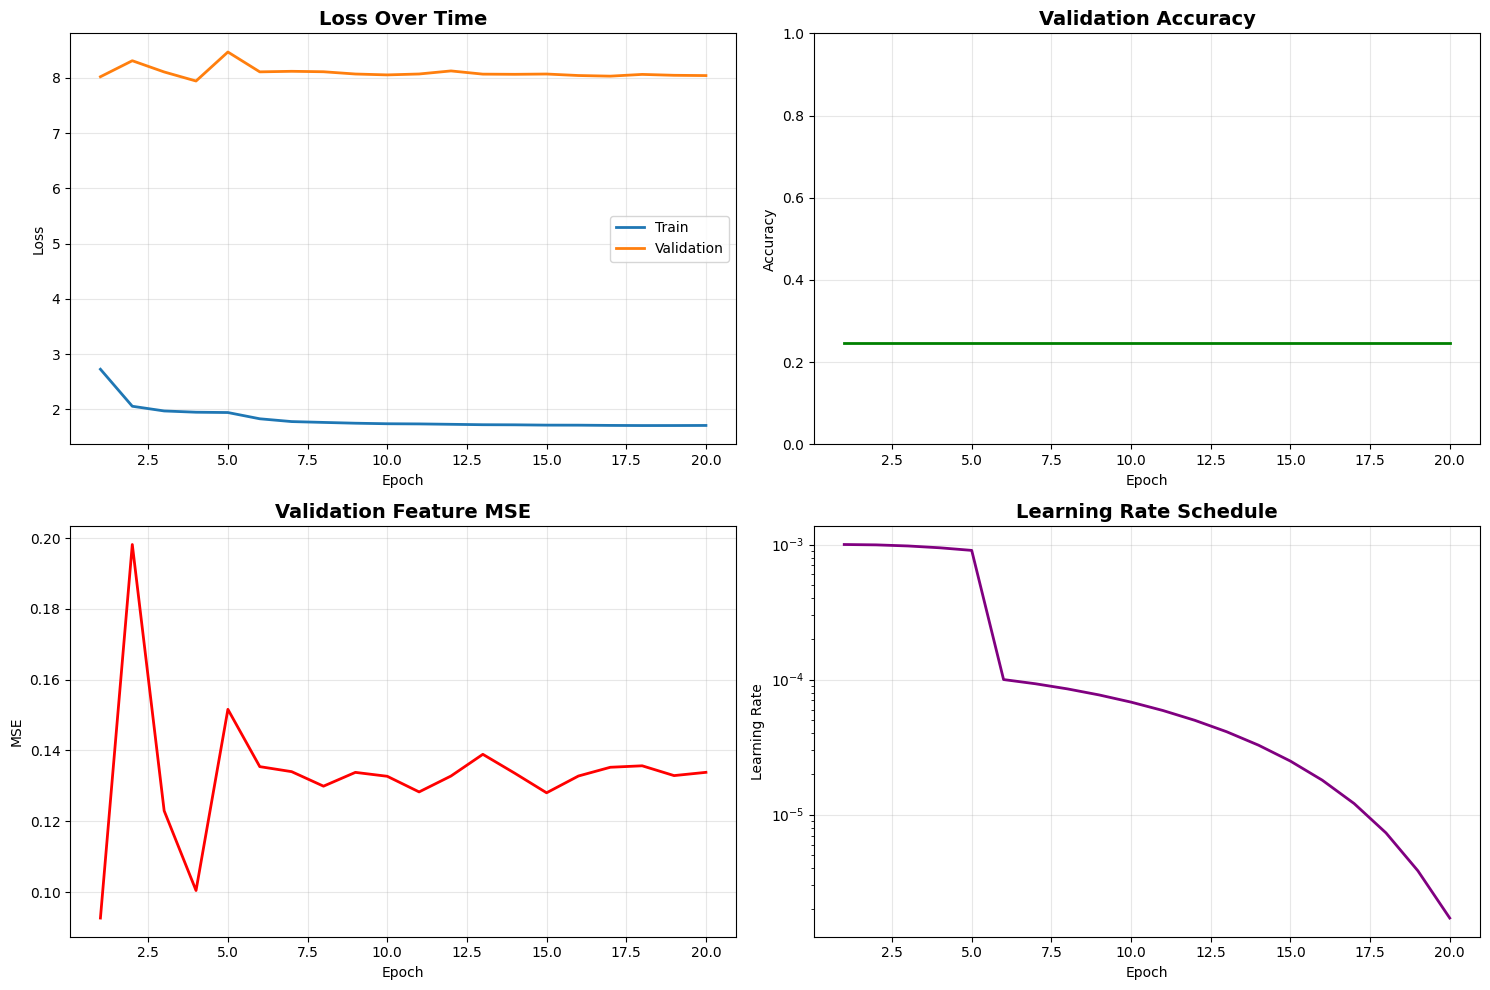

✓ Training curves saved to /kaggle/working/checkpoints/training_curves.png


In [18]:
# ============================================================
# CELL 16: Training Curves Visualization
# ============================================================
print("\n[INFO] Plotting training curves...")

history_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curve
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
axes[0, 1].plot(history_df['epoch'], history_df['val_acc'], linewidth=2, color='green')
axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3)

# MSE curve
axes[1, 0].plot(history_df['epoch'], history_df['val_mse'], linewidth=2, color='red')
axes[1, 0].set_title('Validation Feature MSE', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(history_df['epoch'], history_df['lr'], linewidth=2, color='purple')
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
curves_path = CHECKPOINT_DIR / 'training_curves.png'
plt.savefig(curves_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {curves_path}")


In [19]:
# ============================================================
# CELL 17: Build FAISS Index
# ============================================================
print("\n" + "="*60)
print("BUILDING FAISS INDEX")
print("="*60)

print("[INFO] Preparing feature matrix...")
features_matrix = np.vstack(spotify_df[AUDIO_FEATURES].values).astype(np.float32)
print(f"  • Feature matrix shape: {features_matrix.shape}")

print("[INFO] Normalizing features...")
faiss.normalize_L2(features_matrix)

print("[INFO] Creating FAISS index...")
index = faiss.IndexFlatIP(features_matrix.shape[1])
index.add(features_matrix)

print(f"\n✓ FAISS index created:")
print(f"  • Total tracks indexed: {index.ntotal:,}")
print(f"  • Feature dimension: {features_matrix.shape[1]}")

# Metadata
metadata = spotify_df[['track_id', 'track_name', 'artist_name', 'emotion']].reset_index(drop=True)
print(f"✓ Metadata prepared: {len(metadata):,} tracks")



BUILDING FAISS INDEX
[INFO] Preparing feature matrix...
  • Feature matrix shape: (5782, 13)
[INFO] Normalizing features...
[INFO] Creating FAISS index...

✓ FAISS index created:
  • Total tracks indexed: 5,782
  • Feature dimension: 13
✓ Metadata prepared: 5,782 tracks


In [20]:
# ============================================================
# CELL 18: Inference Function
# ============================================================
@torch.no_grad()
def recommend_tracks(image_path, top_k=10, return_scores=True):
    """Recommend tracks based on an input image"""
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    pixel_values = image_processor(images=image, return_tensors='pt')['pixel_values'].to(device)
    
    # Get predictions
    model.eval()
    outputs = model(pixel_values, audio_features=None)
    predicted = outputs['predicted_features'].cpu().numpy().astype(np.float32)
    
    # Normalize for cosine similarity
    faiss.normalize_L2(predicted)
    
    # Search FAISS index
    scores, ids = index.search(predicted, top_k)
    
    # Get metadata
    recs = metadata.iloc[ids[0]].copy()
    if return_scores:
        recs['similarity'] = scores[0]
    
    return recs

# Test inference
print("\n" + "="*60)
print("TESTING INFERENCE")
print("="*60)

if len(images_df) > 0:
    sample_image = images_df.iloc[0]['path']
    sample_emotion = images_df.iloc[0]['emotion']
    
    print(f"\nSample image: {sample_image.name}")
    print(f"True emotion: {sample_emotion}")
    
    print("\nTop 5 Recommendations:")
    recommendations = recommend_tracks(sample_image, top_k=5)
    print(recommendations[['track_name', 'artist_name', 'emotion', 'similarity']])
    
    print("\n✓ Inference working correctly")



TESTING INFERENCE

Sample image: emid_train-00002-of-00008-03d173a6585297e4_000000_Image1_filename.jpg
True emotion: sadness

Top 5 Recommendations:
                                             track_name      artist_name  \
5256                                 The Mozdok's Train    Anouar Brahem   
5035                                    Second Rhapsody  George Gershwin   
5082  Beautiful Garden in Himalayan Mountains, Class...    Andrei Krylov   
5107         Valse Melancolique No. IV - The Black Swan   Carlos Marquez   
5483                                                Joy            RIOPY   

      emotion  similarity  
5256  sadness    0.986251  
5035  sadness    0.982157  
5082  sadness    0.981197  
5107  sadness    0.980102  
5483  sadness    0.979944  

✓ Inference working correctly


In [21]:
# ============================================================
# CELL 19: Save All Artifacts
# ============================================================
print("\n" + "="*60)
print("SAVING MODEL AND ARTIFACTS")
print("="*60)

# Save model
model_path = CHECKPOINT_DIR / 'dylumo_optimized.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'visual_model': VISUAL_MODEL_NAME,
        'hidden_dim': 512,
        'num_layers': 4,
        'num_heads': 8,
        'emotion_labels': EMOTIONS,
        'audio_features': AUDIO_FEATURES,
    }
}, model_path)
print(f"✓ Model saved: {model_path.name} ({model_path.stat().st_size / 1024 / 1024:.1f} MB)")

# Save scaler
scaler_path = DATA_DIR / 'spotify_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(spotify_scaler, f)
print(f"✓ Scaler saved: {scaler_path.name}")

# Save features
features_path = DATA_DIR / 'spotify_features.npy'
np.save(features_path, spotify_df[AUDIO_FEATURES].values.astype(np.float32))
print(f"✓ Features saved: {features_path.name}")

# Save metadata
metadata_path = DATA_DIR / 'spotify_metadata.parquet'
metadata.to_parquet(metadata_path, index=False)
print(f"✓ Metadata saved: {metadata_path.name}")

# Save FAISS index
index_path = DATA_DIR / 'music_index.index'
faiss.write_index(index, str(index_path))
print(f"✓ FAISS index saved: {index_path.name}")

# Save training history
history_path = CHECKPOINT_DIR / 'training_history.csv'
history_df.to_csv(history_path, index=False)
print(f"✓ History saved: {history_path.name}")

# Save inference requirements (for deployment)
requirements = {
    'visual_model': VISUAL_MODEL_NAME,
    'emotions': EMOTIONS,
    'audio_features': AUDIO_FEATURES,
    'model_params': {
        'hidden_dim': 512,
        'num_layers': 4,
        'num_heads': 8,
        'dropout': 0.3
    },
    'instructions': {
        'load_model': 'Use OptimizedCrossModalTransformer class with saved weights',
        'load_processor': f'CLIPImageProcessor.from_pretrained("{VISUAL_MODEL_NAME}")',
        'load_scaler': 'pickle.load(spotify_scaler.pkl)',
        'load_faiss': 'faiss.read_index(music_index.index)',
        'load_metadata': 'pd.read_parquet(spotify_metadata.parquet)'
    }
}

requirements_path = DATA_DIR / 'deployment_config.json'
with open(requirements_path, 'w') as f:
    json.dump(requirements, f, indent=2)
print(f"✓ Deployment config saved: {requirements_path.name}")

# Save model architecture as Python file (for deployment)
model_code = '''"""
Image-to-Music Recommendation Model
Generated from Kaggle training notebook
"""
import torch
import torch.nn as nn
from transformers import CLIPVisionModel

class OptimizedCrossModalTransformer(nn.Module):
    """Cross-modal transformer for image-to-music recommendation"""
    def __init__(self, visual_model='openai/clip-vit-base-patch32', 
                 hidden_dim=512, num_layers=4, num_heads=8, dropout=0.3,
                 audio_feature_dim=13, num_emotions=7):
        super().__init__()
        
        # Visual encoder (CLIP)
        self.visual_encoder = CLIPVisionModel.from_pretrained(visual_model)
        self.visual_proj = nn.Linear(768, hidden_dim)
        self.visual_dropout = nn.Dropout(dropout)
        
        # Audio embeddings
        self.audio_proj = nn.Linear(audio_feature_dim, hidden_dim)
        self.audio_pos = nn.Parameter(torch.randn(1, 1, hidden_dim) * 0.02)
        self.audio_dropout = nn.Dropout(dropout)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Task heads
        self.emotion_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, num_emotions)
        )
        
        self.feature_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, audio_feature_dim)
        )
        
        self.projection_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 256)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, pixel_values, audio_features=None):
        # Encode visual
        visual_output = self.visual_encoder(pixel_values)
        visual_hidden = visual_output.last_hidden_state
        visual_tokens = self.visual_proj(visual_hidden)
        visual_tokens = self.visual_dropout(visual_tokens)
        
        # Encode audio
        if audio_features is not None:
            audio_tokens = self.audio_proj(audio_features).unsqueeze(1)
            audio_tokens = audio_tokens + self.audio_pos
            audio_tokens = self.audio_dropout(audio_tokens)
        else:
            audio_tokens = self.audio_pos.expand(visual_tokens.size(0), -1, -1)
        
        # Concatenate and transform
        combined = torch.cat([visual_tokens, audio_tokens], dim=1)
        transformed = self.transformer(combined)
        
        # Extract features
        cls_token = transformed[:, 0]
        audio_token = transformed[:, -1]
        
        # Predictions
        emotion_logits = self.emotion_head(cls_token)
        predicted_features = self.feature_head(audio_token)
        embedding = self.projection_head(cls_token)
        
        return {
            'emotion_logits': emotion_logits,
            'predicted_features': predicted_features,
            'embedding': embedding
        }
'''

model_code_path = DATA_DIR / 'model_architecture.py'
with open(model_code_path, 'w') as f:
    f.write(model_code)
print(f"✓ Model architecture saved: {model_code_path.name}")

print("\n" + "="*60)
print("✓ ALL ARTIFACTS SAVED FOR DEPLOYMENT")
print("="*60)
print(f"\nLocation: /kaggle/working/")
print("\nFiles needed for deployment:")
print("  • Model: checkpoints/dylumo_optimized.pt")
print("  • FAISS: data/music_index.index")
print("  • Metadata: data/spotify_metadata.parquet")
print("  • Scaler: data/spotify_scaler.pkl")
print("  • Config: data/deployment_config.json")
print("\nTo download everything:")
print("  !zip -r dylumo_artifacts.zip /kaggle/working/")



SAVING MODEL AND ARTIFACTS
✓ Model saved: dylumo_optimized.pt (368.4 MB)
✓ Scaler saved: spotify_scaler.pkl
✓ Features saved: spotify_features.npy
✓ Metadata saved: spotify_metadata.parquet
✓ FAISS index saved: music_index.index
✓ History saved: training_history.csv
✓ Deployment config saved: deployment_config.json
✓ Model architecture saved: model_architecture.py

✓ ALL ARTIFACTS SAVED FOR DEPLOYMENT

Location: /kaggle/working/

Files needed for deployment:
  • Model: checkpoints/dylumo_optimized.pt
  • FAISS: data/music_index.index
  • Metadata: data/spotify_metadata.parquet
  • Scaler: data/spotify_scaler.pkl
  • Config: data/deployment_config.json

To download everything:
  !zip -r dylumo_artifacts.zip /kaggle/working/


In [22]:
# ============================================================
# CELL 20: Summary & Next Steps
# ============================================================
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Dataset:")
print(f"   Songs used: {len(spotify_df):,}")
print(f"   Images used: {len(images_df):,}")
print(f"   Training pairs: {len(train_df):,}")

print(f"\n📊 Model:")
print(f"   Architecture: Optimized Cross-Modal Transformer")
print(f"   Parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
print(f"   Hidden dim: 512")
print(f"   Layers: 4")

print(f"\n📊 Performance:")
print(f"   Best Val Accuracy: {max([h['val_acc'] for h in history]):.3f}")
print(f"   Test Accuracy: {test_acc:.3f}")
print(f"   Epochs trained: {len(history)}")

print(f"\n📁 Saved Files:")
print(f"   Model: {model_path}")
print(f"   FAISS Index: {index_path}")
print(f"   History: {history_path}")

print("\n✅ TRAINING COMPLETE!")
print("\nNext steps:")
print("  1. Download artifacts: !zip -r artifacts.zip /kaggle/working/")
print("  2. Deploy model for inference")
print("  3. Build web interface for image-to-music recommendations")

print("\n" + "="*60)


TRAINING SUMMARY

📊 Dataset:
   Songs used: 5,782
   Images used: 32,214
   Training pairs: 51,542

📊 Model:
   Architecture: Optimized Cross-Modal Transformer
   Parameters: 96.5M
   Hidden dim: 512
   Layers: 4

📊 Performance:
   Best Val Accuracy: 0.245
   Test Accuracy: 0.250
   Epochs trained: 20

📁 Saved Files:
   Model: /kaggle/working/checkpoints/dylumo_optimized.pt
   FAISS Index: /kaggle/working/data/music_index.index
   History: /kaggle/working/checkpoints/training_history.csv

✅ TRAINING COMPLETE!

Next steps:
  1. Download artifacts: !zip -r artifacts.zip /kaggle/working/
  2. Deploy model for inference
  3. Build web interface for image-to-music recommendations



In [23]:
!pip install tqdm
from tqdm import tqdm
import os
from zipfile import ZipFile, ZIP_DEFLATED

def zip_with_progress(folder_path, zip_path):
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_list.append(os.path.join(root, file))

    with ZipFile(zip_path, 'w', ZIP_DEFLATED) as zipf:
        for file in tqdm(file_list, desc=f"Compressing {folder_path}", ncols=100):
            zipf.write(file)

# Zip the entire working directory
zip_with_progress("/kaggle/working", "full_output.zip")

from IPython.display import FileLink, display

display(FileLink('full_output.zip'))


Compressing /kaggle/working: 100%|███████████████████████████| 32257/32257 [04:23<00:00, 122.58it/s]


/kaggle/working/full_output.zip